# Career Foundry Exercise 6.6 Sourcing & Analyzing Time Series Data
#### Gabriel Pollicar, January 2, 2024

### _________________________________________________________________

## Contents List:


### - 2. Importing Libraries and Datasets
### - 3. Make a subset
### - 4. Create a Line chart of your data
### - 5. Decompose data components
### - 6. Conduct Dickey-Fuller Test
### - 7. Conduct Round of Differencing
### - 8. Check for stationarity, conduct 2nd round of differencing
### - 9. Check for Autocorrelations

### _________________________________________________________________


## 2. Importing Libraries

In [77]:
# Importing Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy
import folium 
import json
import geopandas as gpd

# Modules from Scikit-learn
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

 # Here is where you import the k-means algorithm from scikit-learn.
from sklearn.cluster import KMeans 
import pylab as pl # PyLab is a convenience module that bulk imports matplotlib.

# Importing libraries for Quandl
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import quandl
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. 

In [2]:
# This command propts matplotlib visuals to appear in the notebook 

%matplotlib inline

In [ ]:
# Configure API key 

quandl.ApiConfig.api_key = 'c47WGq4ksXSzzmGLcxR6'

## Importing Datasets

In [3]:
# Importing the realtor data 

path = r'C:\Users\polli\Career Foundry Python'
realtor_data = pd.read_csv(os.path.join(path, 'Exercise 6.4','02 Data', 'realtor-data_Cleaned.csv'))

In [234]:
# Importing the dataset from Quandl library

quandl.ApiConfig.api_key = 'c47WGq4ksXSzzmGLcxR6'
realestate_Value = quandl.get_table('ZILLOW/DATA',indicator_id='SASM', region_id = '395238')

In [235]:
realestate_Value['region_id'].value_counts().head(50)

region_id
395238    189
Name: count, dtype: int64

In [237]:
realestate_Value['region_id'].value_counts()
realestate_Value['region_id'] =realestate_Value['region_id'].astype(int)

realestate_Value.loc[realestate_Value['region_id'] == 395238].head()

,indicator_id,region_id,date,value
None,,,,
0,SASM,395238,2023-10-31,421084.0
1,SASM,395238,2023-09-30,417165.0
2,SASM,395238,2023-08-31,414573.0
3,SASM,395238,2023-07-31,411663.0
4,SASM,395238,2023-06-30,408828.0


#### Dataset:
This dataset is sourced from the Quandl library. It is the median price of real estate sales per month for all United States regions. This data comes from Zillow which is a real estate and rental marketplace. They have extensive property listings, market trends and regional information. This dataset includes monthly dates with the median value of homes sold. It relates to my analysis of real estate price listings of specific states by zip code, sourced from realtor.com. 
# 
The data set was filtered to a single region_id because multiple regions provided multiple median prices on the same date which makes the plot graph non linear. The state that had the most available data points and matched closely with my analysis was the state of Massachusetts, with which I have relating data from my original dataset. 

## 3. Cleaning and Making a Subset

In [240]:
# Removing any missing values in real estate data

realestate_Value = realestate_Value.dropna()
realtor_clean.isnull().sum().sum()

0

In [241]:
# Changing the index into a datetime from the 'date' column

from datetime import datetime

realestate_Value['datetime'] = pd.to_datetime(realestate_Value['date']) # Create a datetime column from "Date.""
realestate_Value = realestate_Value.set_index('datetime') # Set the datetime as the index of the dataframe.
realestate_Value.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
realestate_Value.head()

,indicator_id,region_id,value
datetime,,,
2023-10-31,SASM,395238,421084.0
2023-09-30,SASM,395238,417165.0
2023-08-31,SASM,395238,414573.0
2023-07-31,SASM,395238,411663.0
2023-06-30,SASM,395238,408828.0


In [242]:
# Sort the rows by datetime

realestate_Value = realestate_Value.sort_values(by='datetime')

In [243]:
# Subsetting to just the value column since this is the only variable being measured

realestate_Value = realestate_Value['value']

In [244]:
realestate_Value.head(10)

datetime
2008-02-29    250169.0
2008-03-31    251322.0
2008-04-30    248333.0
2008-05-31    246075.0
2008-06-30    244363.0
2008-07-31    242212.0
2008-08-31    240465.0
2008-09-30    238183.0
2008-10-31    234043.0
2008-11-30    230389.0
Name: value, dtype: float64

## 4. Create a Line Chart

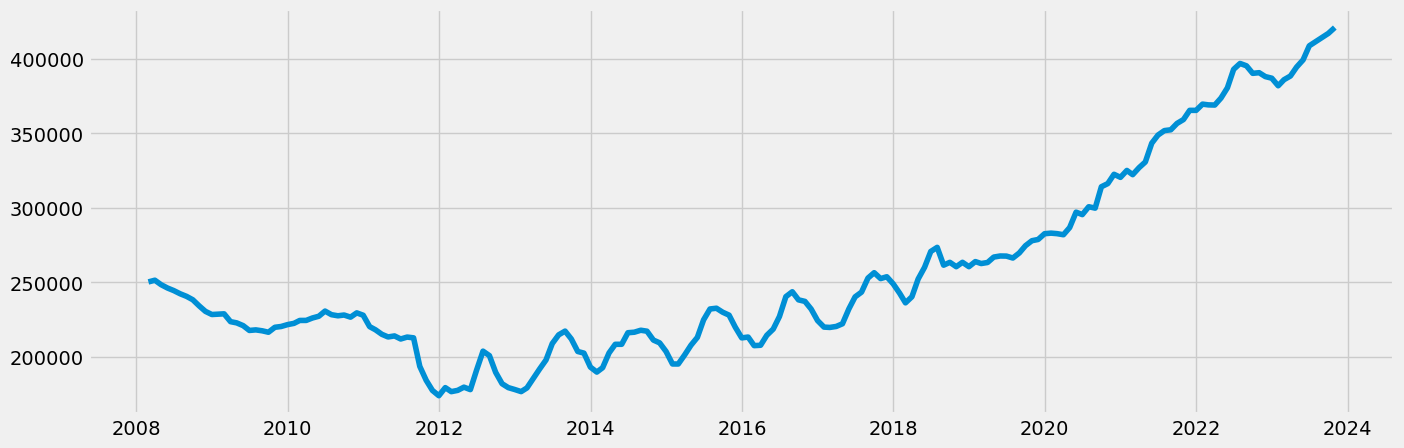

In [245]:
# Line chart shows the median price of homes from the zillow dataset
# I predict that the time series is not stationary because of the large overall growth trend in the data. 

plt.figure(figsize=(15,5), dpi=100)
plt.plot(realestate_Value)

## 5. Decomposing the Data Components

In [250]:
# Performing the decomposition of the time series

decomposition = sm.tsa.seasonal_decompose(realestate_Value, model='additive', period=1)

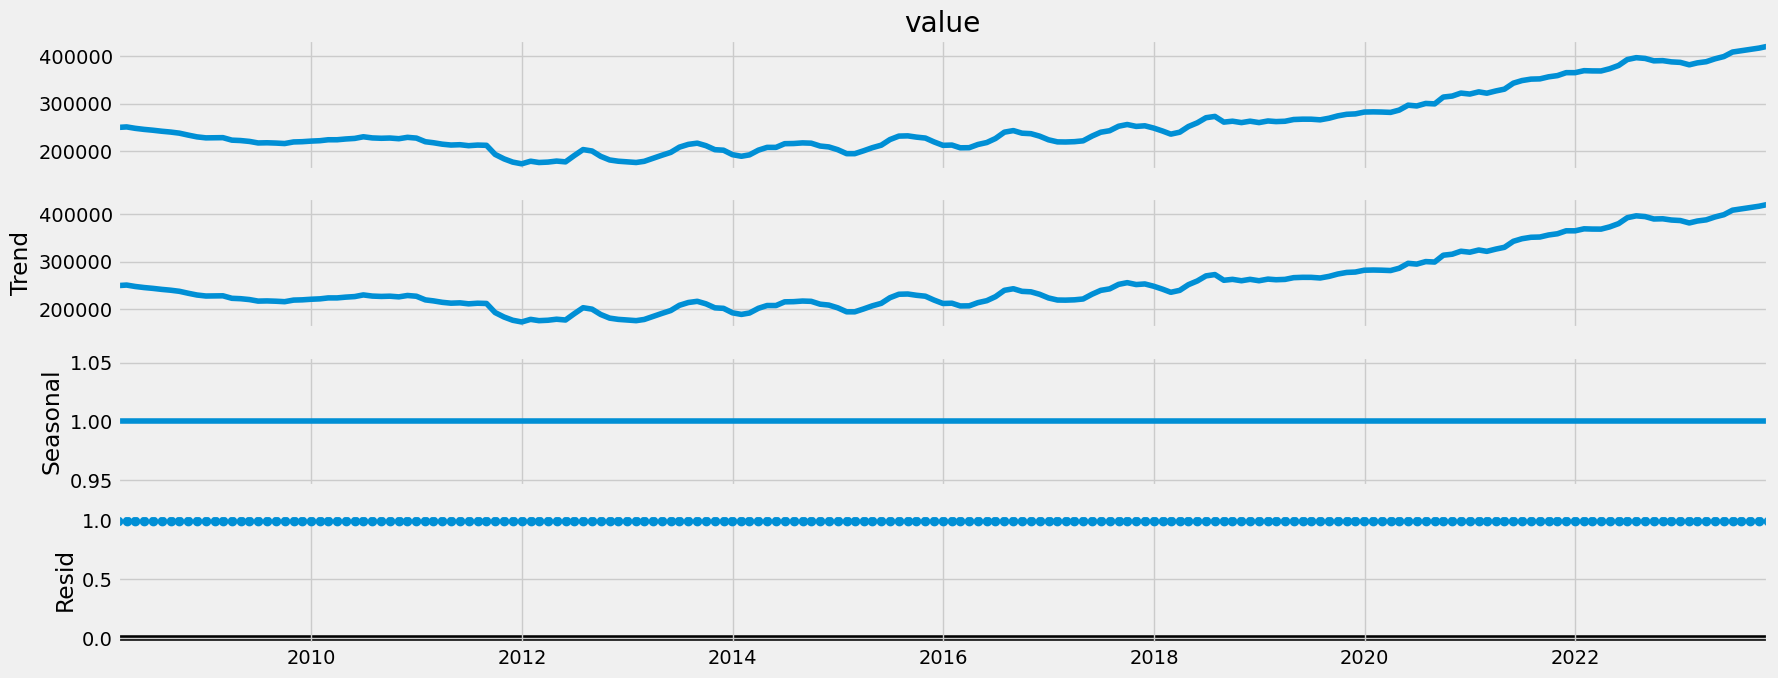

In [251]:
decompose_result = sm.tsa.seasonal_decompose(realestate_Value, model='multiplicative', period=1)
decompose_result.plot();

In [252]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

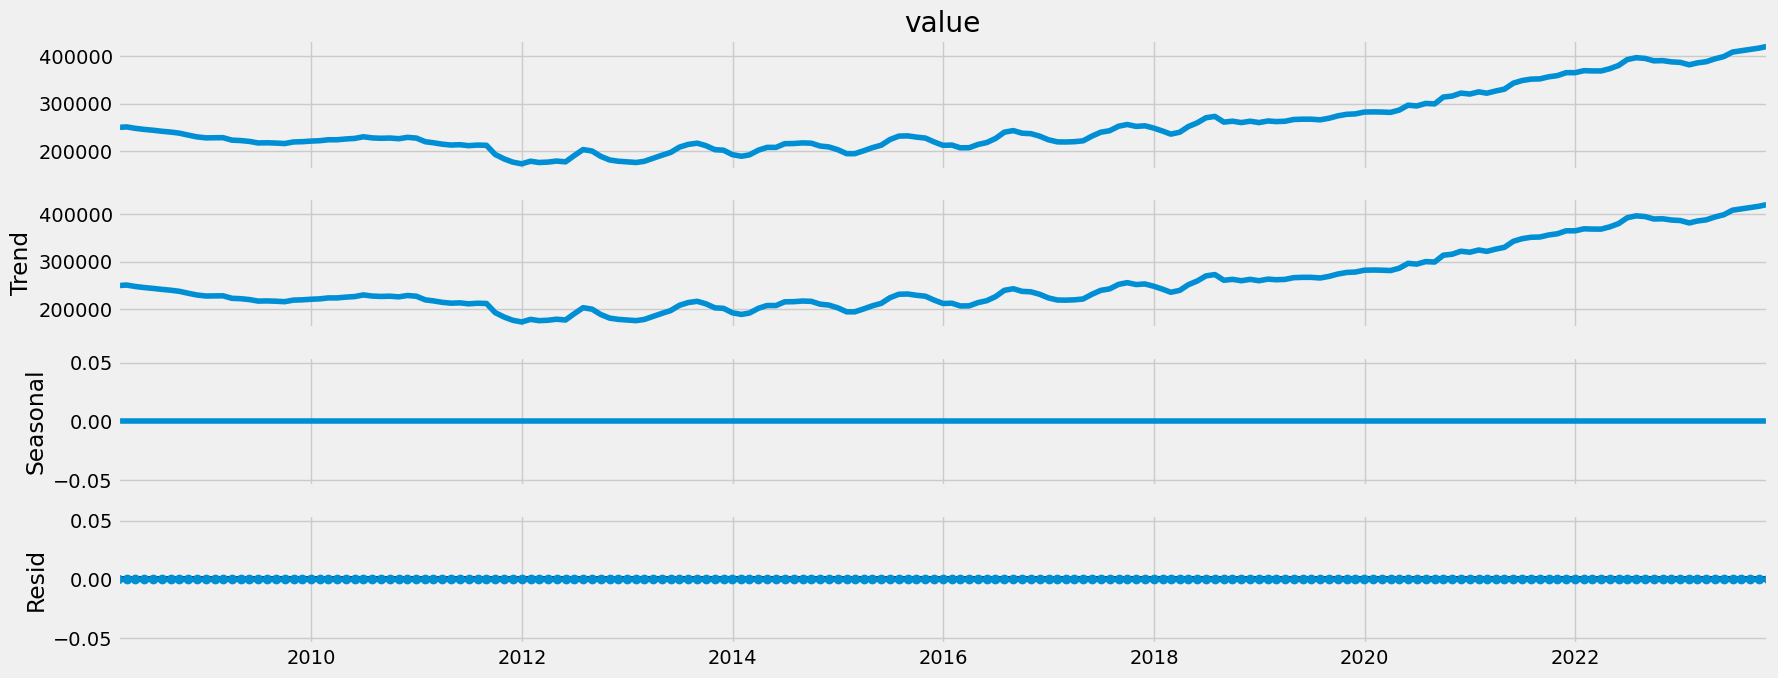

In [253]:
# Plot the separate components

decomposition.plot()
plt.show()

### Observation:
It seems that the data set has a trend where before 2010, the median price of houses sold tend to decrease, then slowly grow again after the housing crash. This data measures median real estate values sold in Massachusetts, so I would expect some growth trends over time caused by the general real estate market regrowth after 2008. There does not seem to be any seasonality since the Seasonal line is flat, and no residual noise or unexpected deviations, since both remain near 0. I expect the data to be non stationary because of the large growth trend and will require stationarizing before being forecast. 

# 
## 5. Conduct a Dickey-Fuller Test
# 

In [269]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(realestate_Value)

# The result shows that the Test Statistic is far larger than the Critical Values. The Test Statistic is .66
# and the Critical Value, I chose 5%, is (-2.87). This means that the null hypothesis can not reject the null
# Hypothesis which is that 

Dickey-Fuller Stationarity test:
Test Statistic                   0.666090
p-value                          0.989136
Number of Lags Used             13.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64


### Observation:
The result shows that the Test Statistic is far larger than the Critical Values. The Test Statistic is .66 and the Critical Value for 5%, is (-2.87). This means that the null hypothesis can not be rejected. The hypothesis states that there is a presence of a unit root in the data therefore, the data is non-stationary and must be stationarized before forecasting. 

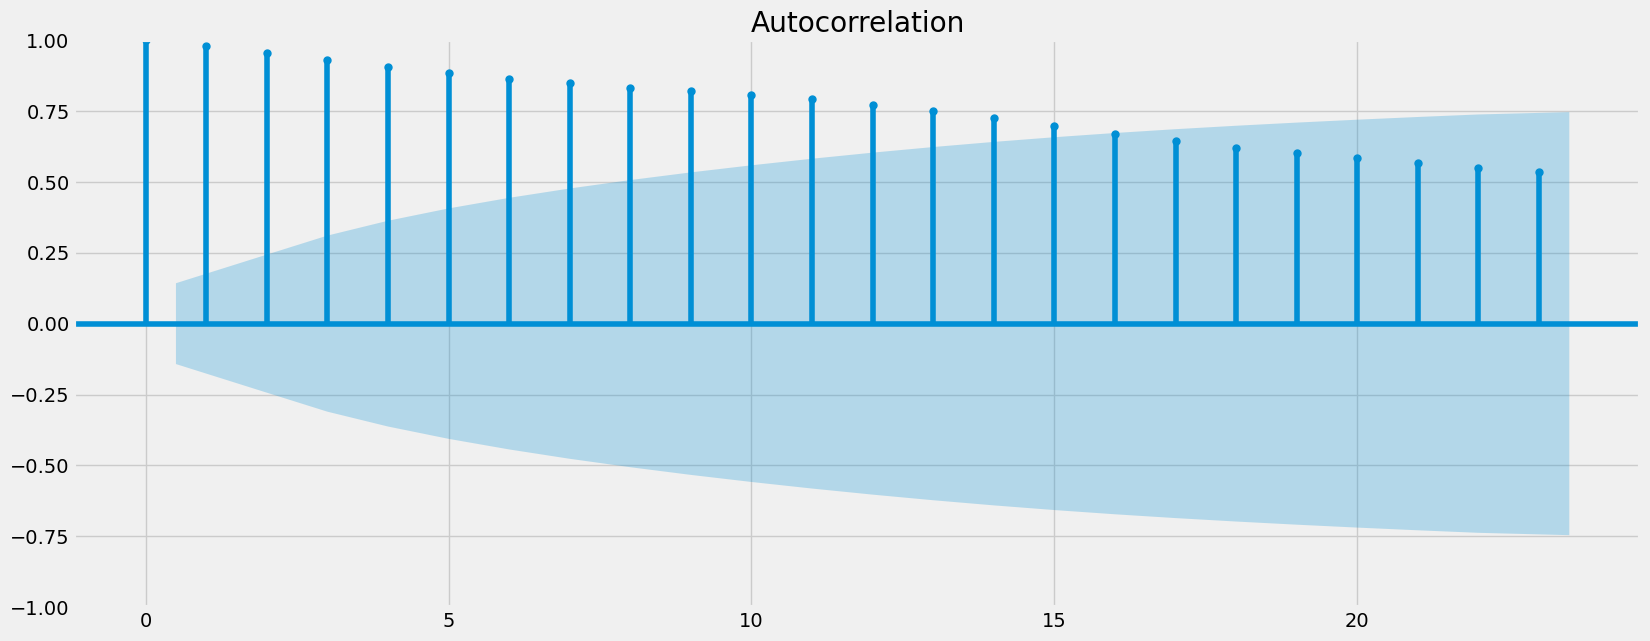

In [270]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(realestate_Value)
plt.show()

## The result here shows that many lags in the series are above the confidence interval. 
# This means that the lags are significantly correlated with each other which makes it likely to 
# be non-stationary. 

# 
## 7. Conduct a Round of Differencing 
# 

In [259]:
# Conducting first round of differencing into new df data_diff

data_diff = realestate_Value - realestate_Value.shift(1) # The df.shift(1) function turns the observation to t-1

In [260]:
# Looking at the data, there seems to be a NaN value from the differencing 

data_diff.head()

datetime
2008-02-29       NaN
2008-03-31    1153.0
2008-04-30   -2989.0
2008-05-31   -2258.0
2008-06-30   -1712.0
Name: value, dtype: float64

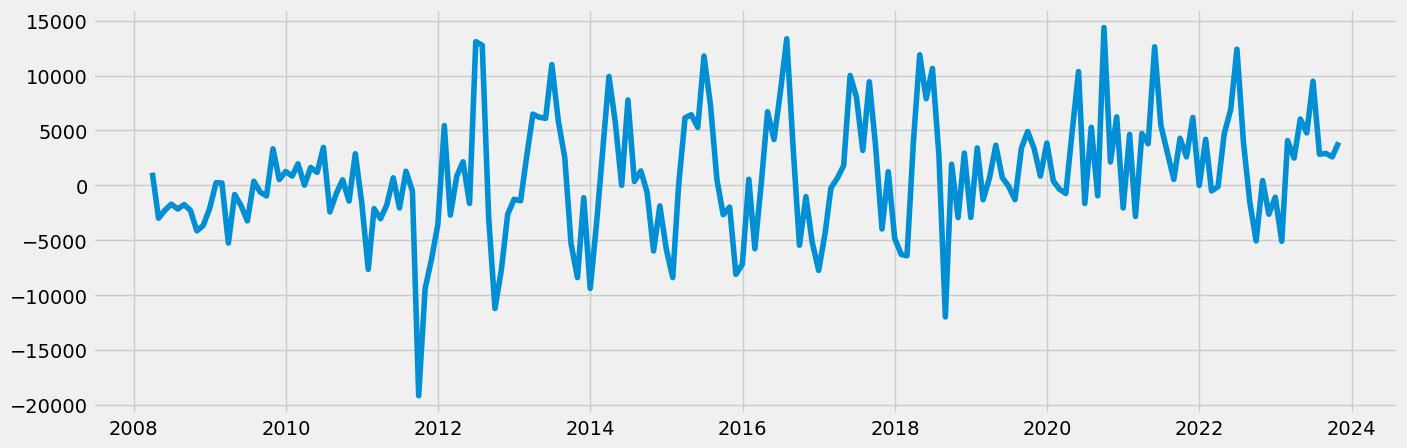

In [264]:
# Visualizing the new plot point after differencing 

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

# Result shows the transformed time series with values each subtracted by the previous data point. 
# There does not seem to be a growing trend line anymore nor any seasonality or unexpected noise.
# Which could point to the data now being stationary. 

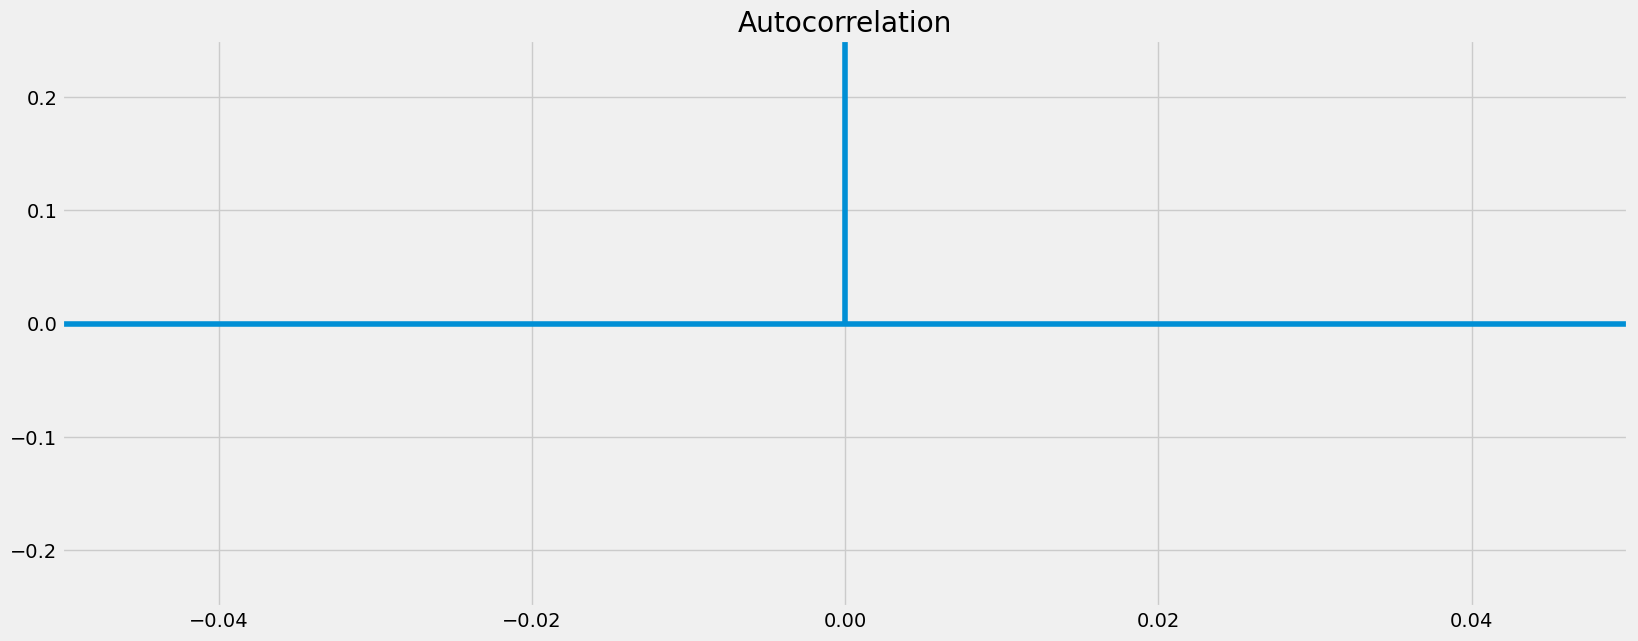

In [284]:
# Using the Autocorrelation chart to see the lagged dataset and check for stationarity
# 
data_diff = data_diff.dropna()
plot_acf(data_diff)

# Zooming in on the data
plt.axis([-.05, .05, -.25, .25])
plt.show()

# The autocorrelation chart either shows that the autocorrelated terms have very small differences 
# or there is an error in the chart. The chart can be overdifferenced or underdifferenced. 

In [272]:
# Checking for stationarity using dickey fuller test

# Removing the null value of the first row caused by differencing. 
data_diff = data_diff.dropna()
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.133498
p-value                          0.231260
Number of Lags Used             12.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64


### Observation:
The DickeyFuller test shows that the Test Statistic is still somewhat higher than the Critical Value of 5% and for the 1%. The Test statistic is -2.13 and the critical value is -2.8. This means that there is still some stationarity in the data. The null hypothesis cannot yet be rejected. A second round of differencing is needed. 

# 
## 8. Perform Second Round of Differencing 
# 

In [273]:
# Differencing the previous dataset data_diff into data_diff2

data_diff2 = data_diff - data_diff.shift(1) # The df.shift(1) function turns the observation to t-1

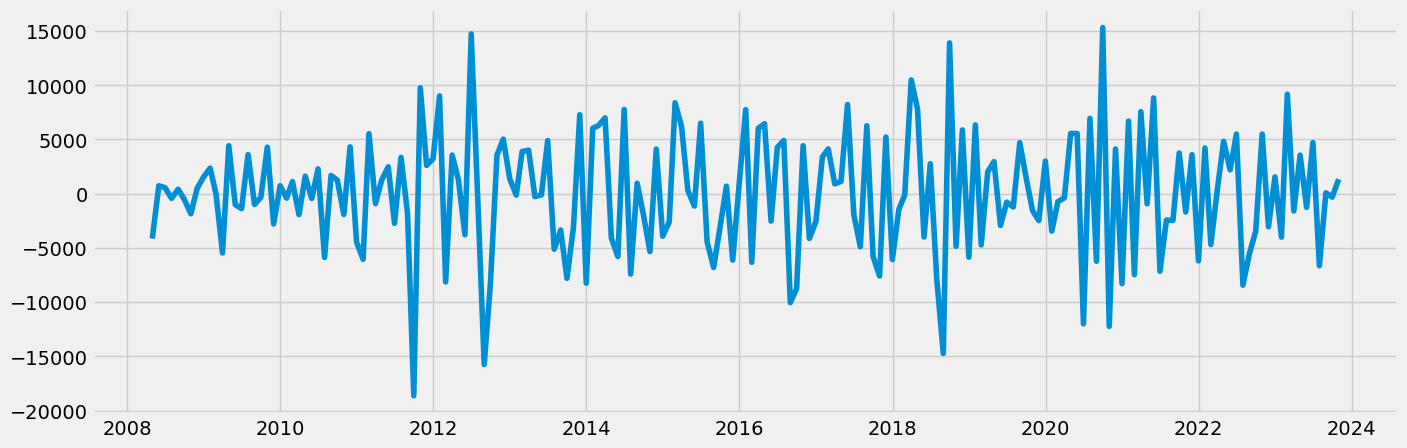

In [279]:
# Visualizing the new plot point after second round of differencing 

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff2)

# Result shows the transformed time series differenced twice
# There does not seem to be a growing trend line anymore nor any seasonality or unexpected noise.
# Which could point to the data now being more stationary. 

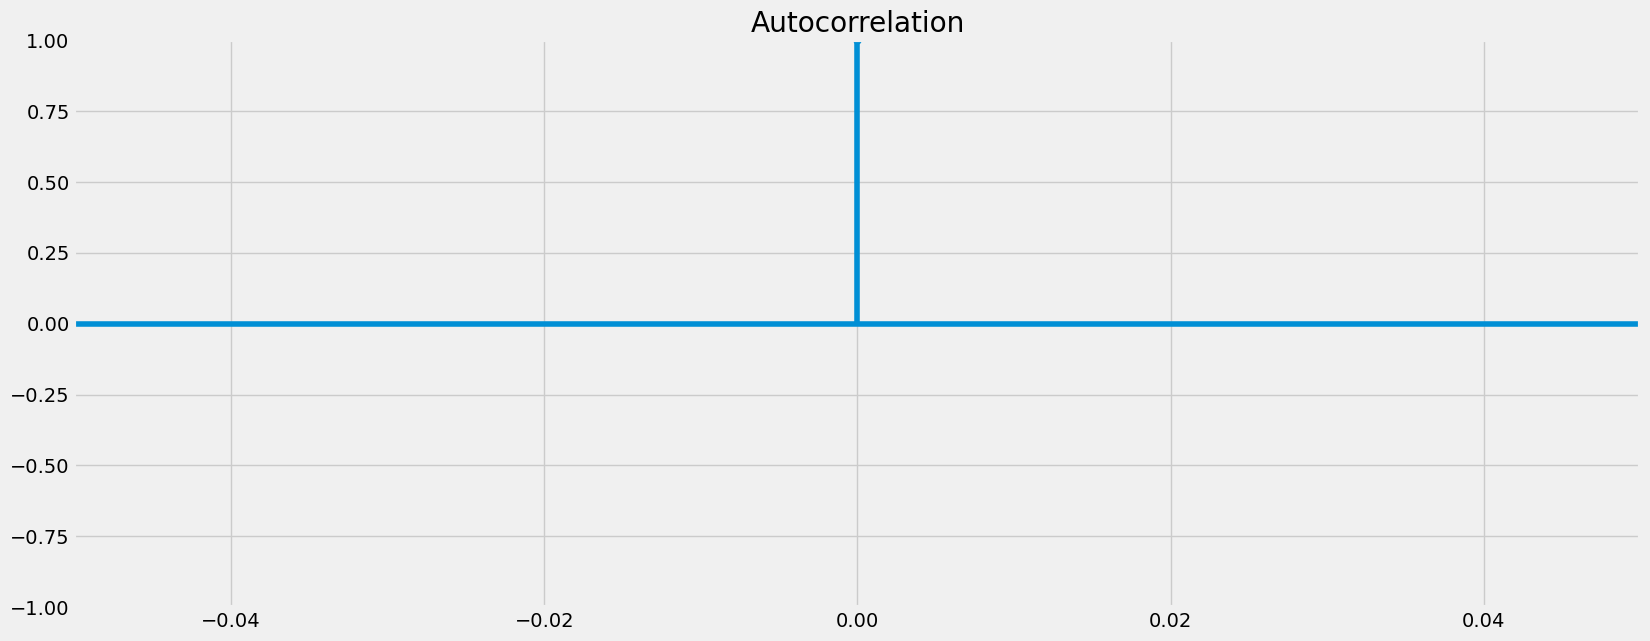

In [301]:
# Using the Autocorrelation chart to see the lagged dataset and check for stationarity

# Remove missing value
data_diff2 = data_diff2.dropna()
plot_acf(data_diff2)

# Zooming in on the data
plt.axis([-.05, .05, -1, 1])
plt.show()

# The autocorrelation chart again shows that the autocorrelated terms have very small differences 
# or there is an error in the chart. The chart can be overdifferenced or underdifferenced. 

In [302]:
# Checking for stationarity using dickey fuller test

# Removing the null value of the first row caused by differencing. 
data_diff2 = data_diff2.dropna()
dickey_fuller(data_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                -1.034496e+01
p-value                        2.625662e-18
Number of Lags Used            1.100000e+01
Number of Observations Used    1.750000e+02
Critical Value (1%)           -3.468280e+00
Critical Value (5%)           -2.878202e+00
Critical Value (10%)          -2.575653e+00
dtype: float64


### Observation:
It seems that differencing twice has helped remove the stationarity in the dataset. The Test Statistic is -10.34496 while the Critical Value for 1% is -3.468280. This means that the Test Statistic is far less than the Critical Value and therefore, the null hypothesis can be rejected. The time series is stationarized. 

#
## 9. Autocorrelation
#

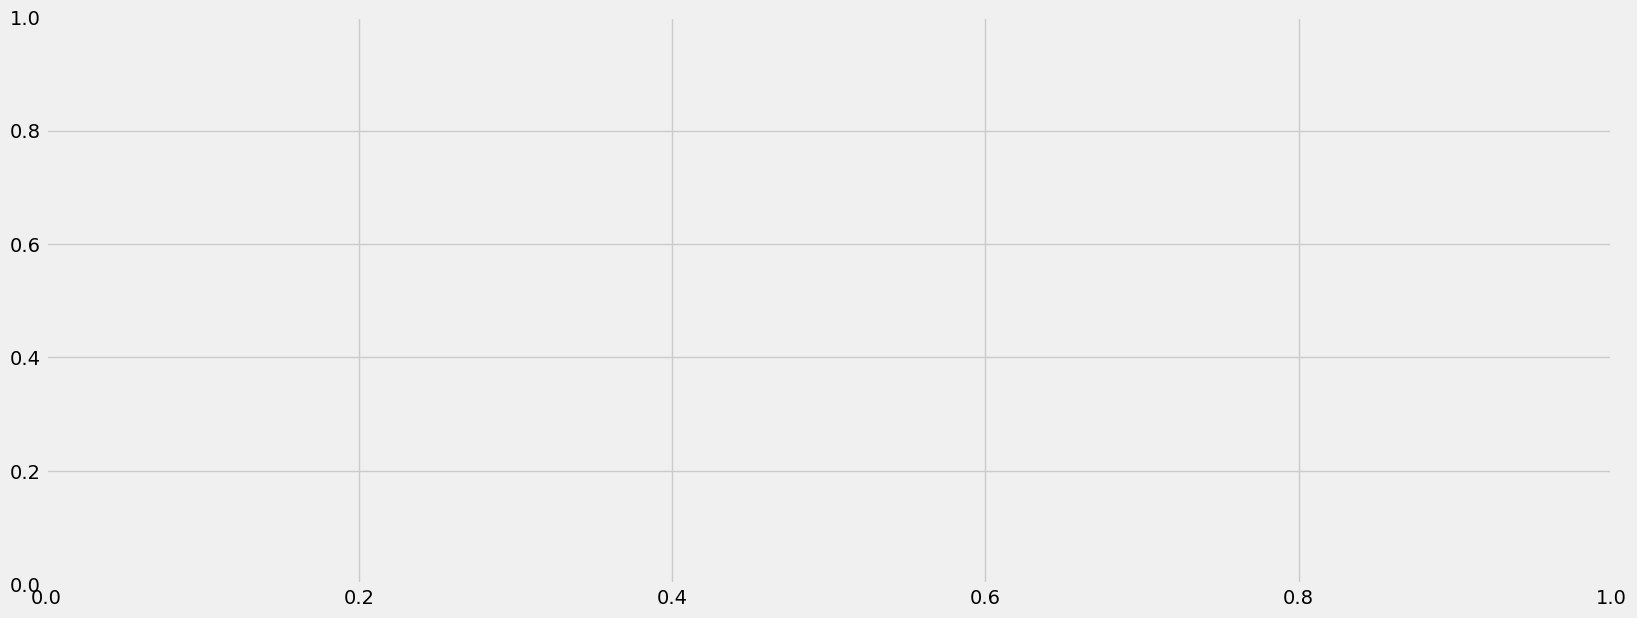

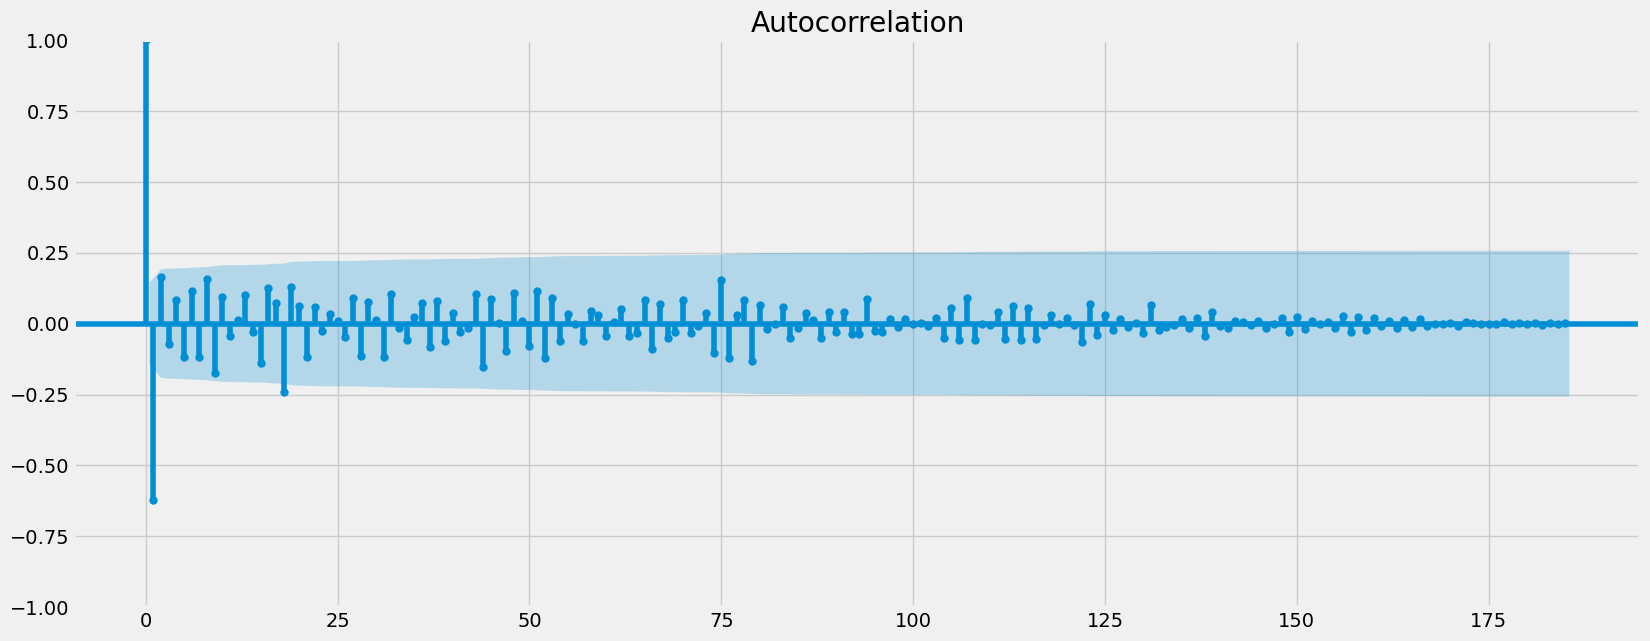

In [303]:
# This is a code I found online,
# seems to show autocorrelation of the time series after 2nd round of differencing
fig, axes = plt.subplots(1, 1, sharex=True)
plot_acf(data_diff2.diff().dropna(), lags=np.arange(len(data_diff2) - 1))
plt.show()

### Observation:
Autocorrelation seems to show the majority of lag values below the confidence interval after the second differencing, so this supports the conclusion that the time series is now stationarized. 